# Mini Spark Broker: Connection to the stream

author: **Julien Peloton** [@JulienPeloton](https://github.com/JulienPeloton)  
Last Verifed to Run: 2019-02-01


The purpose of this notebook is to test Spark Streaming capability in the context of the DESC Broker design. 

**Useful Links:**

* https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html
* https://databricks.com/blog/2017/02/23/working-complex-data-formats-structured-streaming-apache-spark-2-1.html
* https://databricks.com/blog/2016/07/28/structured-streaming-in-apache-spark.html
* https://docs.databricks.com/_static/notebooks/structured-streaming-python.html
* https://spark.apache.org/docs/2.2.0/structured-streaming-kafka-integration.html

## Step 0: Running the LSST alert system

In order to play with this notebook, you need to create the stream of alerts. This is handled by the [lsst-dm/alert_stream](https://github.com/lsst-dm/alert_stream) repository, maintained by the LSST DM group. Here are the steps you need in case you did not yet:

```bash
# clone the repo
git clone https://github.com/lsst-dm/alert_stream.git
cd alert_stream

# Launch Zookeeper and Kafka servers
docker-compose up -d

# Build the alert stream image
docker build -t "alert_stream" .

# Send bursts of alerts at expected visit intervals to topic "my-stream":
docker run -it --rm \
    --network=alert_stream_default \
    -v $PWD/data:/home/alert_stream/data:ro \
    alert_stream python bin/sendAlertStream.py kafka:9092 my-stream
```

At this stage the stream is created, and 4 alerts will be sent at ~30 seconds interval. No worry if it finishes before you started working, you will be able to consume them on a later time (and you can always relaunch the stream).

## Step 1: Connecting to the stream with Apache Spark

Once the stream is produced, you want to connect to it and read messages.

In [2]:
from pyspark.sql import SparkSession

# Grab the running Spark Session, 
# otherwise create it.
spark = SparkSession \
    .builder \
    .appName("test") \
    .getOrCreate()

Let's initialise a DataFrame that will read the stream from Kafka. Note that `kafka.bootstrap.servers` and `subscribe` must correspond to the arguments used for the LSST alert system (see above). At this point, we just create a Kafka Source for Streaming Queries - nothing really happens:

In [3]:
# Create a DF from the incoming stream from Kafka
# Note that <kafka.bootstrap.servers> and <subscribe>
# must correspond to arguments of the LSST alert system.
df = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "kafka:9092") \
  .option("subscribe", "my-stream") \
  .option("startingOffsets", "earliest") \
  .load()

df.isStreaming

True

As you can see, `df` is a streaming Dataframe. You can start streaming computation, by defining the sink and starting it. 
<!-- In our case, we want to interactively query the counts (same queries as above), so we will set the complete set of 1 hour counts to be in a in-memory table (note that this for testing purpose only in Spark 2.0). -->

## Step 2: First interaction with the stream

Let's see first if we can receive correctly alert packets. For this, we define a query to the stream that will just count in real-time the number of alerts received by Spark:

In [17]:
from pyspark.sql.functions import window

# We group data by partitions, 
# and count the number of alerts per partition
# every 30 seconds.
streamingCountsDF = (
  df.groupBy(
      "partition", 
      window("timestamp", "30 second"))
    .count()
)

In [18]:
# keep the size of shuffles small
spark.conf.set("spark.sql.shuffle.partitions", "2")  

# Trig`ger the streaming computation, 
# by defining the sink (memory here) and starting it
countQuery = streamingCountsDF \
    .writeStream \
    .queryName("qcount")\
    .format("memory")\
    .outputMode("complete") \
    .start()

`qcount` is a handle to the streaming query that is running in the background. This query is continuously picking up alerts and updating the counts. You can easily access information about the progress in real-time:

{'id': '66c9afa8-54a2-4226-96cc-5b3f6d2b2011', 'runId': 'a62e3ffe-a40e-49ea-b8eb-16feee24bfd2', 'name': 'qcount', 'timestamp': '2019-02-02T23:43:54.324Z', 'batchId': 0, 'numInputRows': 499, 'processedRowsPerSecond': 72.75112990231813, 'durationMs': {'addBatch': 2814, 'getBatch': 0, 'getEndOffset': 0, 'queryPlanning': 342, 'setOffsetRange': 3364, 'triggerExecution': 6859, 'walCommit': 164}, 'stateOperators': [{'numRowsTotal': 17, 'numRowsUpdated': 17, 'memoryUsedBytes': 4109, 'customMetrics': {'loadedMapCacheHitCount': 0, 'loadedMapCacheMissCount': 0, 'stateOnCurrentVersionSizeBytes': 3821}}], 'sources': [{'description': 'KafkaV2[Subscribe[my-stream]]', 'startOffset': None, 'endOffset': {'my-stream': {'0': 499}}, 'numInputRows': 499, 'processedRowsPerSecond': 72.75112990231813}], 'sink': {'description': 'MemorySink'}}


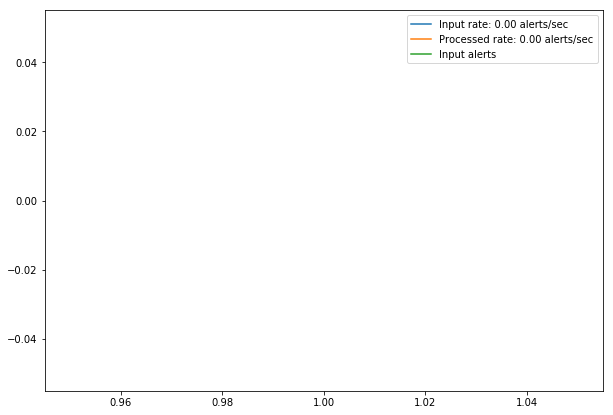

[]


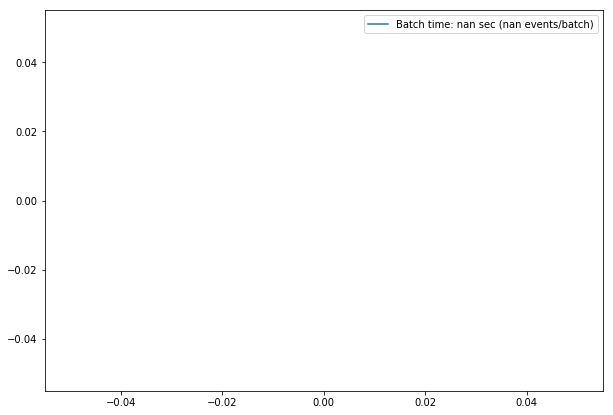

In [25]:
# Pick up recent progress
import matplotlib.pyplot as pl
import numpy as np

rp = countQuery.recentProgress
print(rp[0])

row_input_persec = [rp[i]["sources"][0]["inputRowsPerSecond"] for i in range(1, len(rp))]
row_processed_persec = [rp[i]["sources"][0]["processedRowsPerSecond"] for i in range(1, len(rp))]
time = [rp[i]["batchId"] for i in range(1, len(rp))]
num_row = [rp[i]["numInputRows"] for i in range(1, len(rp))]

fig = pl.figure(figsize=(10, 7))
pl.plot(time, row_input_persec, label="Input rate: {:.2f} alerts/sec".format(np.mean(row_input_persec)))
pl.plot(time, row_processed_persec, label="Processed rate: {:.2f} alerts/sec".format(np.mean(row_processed_persec)))
pl.plot(time, num_row, label="Input alerts")
# pl.ylim(0, 1500)
pl.legend()
pl.show()

fig = pl.figure(figsize=(10, 7))

mask = np.where(np.array(row_processed_persec) > 0)[0]
speed = np.array([i/j for i, j in zip(np.array(num_row)[mask], np.array(row_processed_persec)[mask])])
print(np.array(row_processed_persec)[mask])
pl.plot(np.array(time)[mask], speed, label="Batch time: {:.2f} sec ({:.2f} events/batch)".format(
    np.mean(speed), 
    np.mean(np.array(num_row)[mask])))
pl.legend()
pl.show()

In [26]:
# al = spark.sql(
#     "select partition, date_format(window.end, 'YYYY-MMM-dd HH:mm:ss') as time, count from qcount order by time, partition")
al = spark.sql(
    "select partition, date_format(window.end, 'HH:mm:ss') as time, count from qcount order by time, partition")

In [27]:
# al.withColumn("rate (events/seconds)", rate(al["count"], 30.)).show()
al.show()
pandas_df = al.toPandas()

+---------+--------+-----+
|partition|    time|count|
+---------+--------+-----+
|        0|23:25:00|   11|
|        0|23:25:30|   31|
|        0|23:26:00|   31|
|        0|23:26:30|   31|
|        0|23:27:00|   31|
|        0|23:27:30|   31|
|        0|23:28:00|   31|
|        0|23:28:30|   31|
|        0|23:29:00|   30|
|        0|23:29:30|   31|
|        0|23:30:00|   31|
|        0|23:30:30|   31|
|        0|23:31:00|   31|
|        0|23:31:30|   31|
|        0|23:32:00|   31|
|        0|23:32:30|   31|
|        0|23:33:00|   24|
+---------+--------+-----+



499


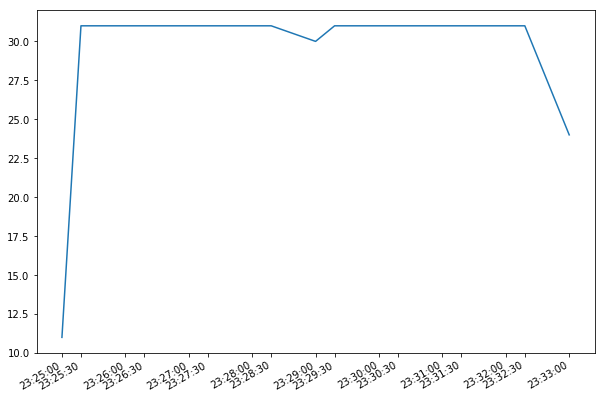

In [28]:
fig = pl.figure(figsize=(10, 7))
times = [int(i.replace(":", "")) for i in pandas_df["time"]]
pl.plot(times, pandas_df["count"])
pl.xticks(times, pandas_df["time"][:])
pl.gcf().autofmt_xdate()
print(pandas_df["count"].sum())

In [ ]:
countQuery.stop()

## Step 4: Digging the alerts

In [4]:
# ds = df.selectExpr("CAST(value AS STRING)")
rawQuery = df\
    .writeStream \
    .queryName("qraw")\
    .format("memory")\
    .start()

In [16]:
from ast import literal_eval
al = spark.sql("select * from qraw")
al.show()

# Look at one alert
alert = al.select(al["value"].cast("string")).rdd.take(1)
literal_eval(list(a)[0])

{'schemavsn': '3.2',
 'publisher': 'ZTF (www.ztf.caltech.edu)',
 'objectId': 'ZTF18abyouwp',
 'candid': 697251920015010010,
 'candidate': {'jd': 2458451.7519213,
  'fid': 1,
  'pid': 697251920015,
  'diffmaglim': 19.647123336791992,
  'pdiffimfilename': 'ztf_20181129251771_000248_zg_c01_o_q1_scimrefdiffimg.fits',
  'programpi': 'Kulkarni',
  'programid': 1,
  'candid': 697251920015010010,
  'isdiffpos': 'f',
  'tblid': 10,
  'nid': 697,
  'rcid': 0,
  'field': 248,
  'xpos': 1817.9852294921875,
  'ypos': 2753.298828125,
  'ra': 26.8566983,
  'dec': -26.9677112,
  'magpsf': 14.283452987670898,
  'sigmapsf': 0.038736678659915924,
  'chipsf': 50.48195266723633,
  'magap': 14.340100288391113,
  'sigmagap': 0.008100000210106373,
  'distnr': 0.24791085720062256,
  'magnr': 12.048999786376953,
  'sigmagnr': 0.012000000104308128,
  'chinr': 0.6589999794960022,
  'sharpnr': 0.032999999821186066,
  'sky': 0.5009307861328125,
  'magdiff': 0.05664699897170067,
  'fwhm': 2.3299999237060547,
  'clas

In [ ]:
raw = spark.sql("select * from qraw")
raw.show()
raw.printSchema()

In [ ]:
schema_files = ["../../sample-avro-alert/schema/diasource.avsc",
                    "../../sample-avro-alert/schema/diaobject.avsc",
                    "../../sample-avro-alert/schema/ssobject.avsc",
                    "../../sample-avro-alert/schema/cutout.avsc",
                    "../../sample-avro-alert/schema/alert.avsc"]
import fastavro
import avro.schema
import json
def loadSingleAvsc(file_path, names):
    """Load a single avsc file.
    """
    with open(file_path) as file_text:
        json_data = json.load(file_text)
    schema = avro.schema.SchemaFromJSONData(json_data, names)
    return schema
def combineSchemas(schema_files):
    """Combine multiple nested schemas into a single schema.
    """
    known_schemas = avro.schema.Names()

    for s in schema_files:
        schema = loadSingleAvsc(s, known_schemas)
    return schema.to_json()
schema = combineSchemas(schema_files)
import io

def decoder(msg):
    bytes_io = io.BytesIO(msg)
    bytes_io.seek(0)
    alert = fastavro.schemaless_reader(bytes_io, schema)
    return alert

In [ ]:
schema

In [ ]:
data = raw.take(1)
val = data[0]["value"]
val

In [ ]:
decoder(val)

In [ ]:
# from pyspark.sql.functions import col, pandas_udf
# from pyspark.sql.types import json
# decode = pandas_udf(decoder, returnType=)
rdd = raw.rdd.map(lambda x: decoder(x[1]))

In [ ]:
def takeRADecPart(part):
    data = [*part]
    alert = [i["alertId"] for i in data]
    ra = [i["diaSource"]["ra"] for i in data]
    dec = [i["diaSource"]["decl"] for i in data]
    
    yield alert, ra, dec
def takeRADec(dic):
    alert = dic["alertId"]
    ra = dic["diaSource"]["ra"]
    dec = dic["diaSource"]["decl"]
    
    return (alert, ra, dec)
df = rdd.map(takeRADec).toDF()

In [ ]:
df.count()

In [ ]:
df.show()

In [ ]:
from pyspark.sql import Row
dic = {"toto":1, "tata":2}
r = Row(**decoder(val))
print(r)

def as_row(obj):
    if isinstance(obj, dict):
        dictionary = {k: as_row(v) for k, v in obj.items()}
        return Row(**dictionary)
    elif isinstance(obj, list):
        return [as_row(v) for v in obj]
    else:
        return obj

def makeRow(dic):
    myRow = Row(**dic)
#     myRow = as_row(dic)
    return myRow

df2 = rdd.map(makeRow)
# schemal = [(i, j) for i, j in zip(schema.keys(), schema.values())]
# df2 = spark.createDataFrame(rdd.map(makeRow), schemal)

In [ ]:
df2.take(10)

In [ ]:
[i["type"] for i in schema["fields"]]

In [ ]:
from pyspark.sql.functions import pandas_udf, PandasUDFType

# Use pandas_udf to define a Pandas UDF
@pandas_udf('double')
# Input/output are both a pandas.Series of doubles
def decoderudf(msg):
    bytes_io = io.BytesIO(msg)
    bytes_io.seek(0)
    alert = fastavro.schemaless_reader(bytes_io, schema)
    return alert

raw.withColumn("decoded", decoderudf(raw["value"])).show()

In [ ]:
from pyspark.sql.types import StringType, LongType
from pyspark.sql.types import StructType
from pyspark.sql.functions import udf, explode, split, from_json

dec = udf(decoder, StringType())

In [ ]:
dfdec = raw.withColumn("decoded", dec(raw["value"])).select("decoded")
dfdec.show()
dfdec.take(1)

In [ ]:
from ast import literal_eval

def str2dic(s):
    return literal_eval(s)
    
str2dic_udf = udf(str2dic)
# dfdec.select("decoded", str2dic_udf(dfdec["decoded"])).show()
dfdec.rdd.map(lambda x: x.asDict()).take(2)

## Step 5: cross-correlating with other catalogs